# Assignment 2 - Discovery of Frequent Itemsets and Association Rules

## By Sachin Prabhu Ram and Anirudh Tiwari

In this report, we will go through the method of discovering frequent itemsets and the association rules between them. The problem that we approaching is that of frequent itemsets in a basket of transactions. We do this by defining two integral terms: Support (s) and Confidence (c). **Support** measures how frequently an item X occurs in the dataset; it is calculated as the number of transactions containing X divided by the total number of transactions. **Confidence** rules between two items X and Y measures the fraction of baskets with of all of X containing Y. Using these metrics, we can also find the **Interest** of an association rule, which is the confidence - support.

Some terms constantly used are singletons, doubletons and tripletons, commonly known as k-itemsets, where k is an integer that represents the length of the set. Singletons contain one element in a basket, doubletons, two and so on. 

This specific dataset (T10I4D100K.dat) contains a list of 100,000 transactions, each with varying lengths and items, where each item is represented by a number. The technology stack used is Python without any framework. We only utilise libraries such as collections and itertools. 

### Data Parsing

To read in the content of the file, we use the data_parser function below. The sole parameter of the function is the name of the data file, which will be passed as a string. We initialise an empty list that is used to store the sets. We then read every line in the file, format the line for processing and add each line into its own individual set. The list of sets is then returned.

In [1]:
def data_parser(data_file):
    set_list = []
    with open(data_file, 'r') as df:
        for line in df:
            line = line.strip().split()
            individual_set = set(int(x) for x in line)
            set_list.append(individual_set)

    return set_list


data_file = "T10I4D100K.dat"

### A-Priori Algorithm

There are two functions below: One to get the frequent singletons and one to get the frequent k itemsets. To get the frequent singletons, we create an array that holds all of the individual items and set item_count to be a dictionary with the item as the key and count as the value. We then initialise a dictionary called `frequent_singletons`. We then loop through the item_count hash item, and only keep the elements that are considered 'frequent' (i.e. above the support threshold)

To get the frequent k itemsets, we need the following parameters: The previous k-ton (i.e. if we want to find the tripleton, we load in the frequent doubletons), the transactions (the parsed data file), the support threshold and the k value of the itemset we are trying to find. 

We add the keys of the previous_k_ton to the set called frequent items. We then have a dictionary for candidate_counts (i.e. the count of candidate pairs). The line t & frequent_items is a massive optimisation tool, as instead of parsing through **every** transaction, we only go through the relevant ones. We then update the count of each candidate to get the candidate count dictionary. We iterate through the dictionary and if the count is higher than the support threshold, we declare it a frequent item and append it to the dictionary along with its count. 

In [2]:
from collections import Counter
from itertools import combinations

def get_frequent_singletons(data, support):
    all_items = []
    for d in data:
        for item in d:
            all_items.append(item)
    
    item_count = Counter(all_items)
    frequent_singletons = {}
    
    for item, count in item_count.items():
        if count >= support:
            itemset = frozenset({item})
            frequent_singletons[itemset] = count
    
    return frequent_singletons


def get_frequent_k_itemsets(previous_k_ton, transaction, support, k):
    frequent_items = set()
    for itemset in previous_k_ton.keys():
        for item in itemset:
            frequent_items.add(item)
    
    candidate_counts = {}
    
    for t in transaction:
        relevant_items = t & frequent_items
        
        for pair in combinations(relevant_items, k):
            candidate = frozenset(pair)
            
            if candidate in candidate_counts:
                candidate_counts[candidate] += 1
            else:
                candidate_counts[candidate] = 1
    
    frequent_k_tons = {}
    for candidate, count in candidate_counts.items():
        if count >= support:
            frequent_k_tons[candidate] = count
    
    return frequent_k_tons    

### Generating Association Rules (Bonus Point Assignment)

In this function, we look at generating association rules. This helps us find out whether frequent itemsets are a pattern or simply a coincidence. We have an array called rules, which stores the rules to be returned. We then find the confidence using the count of the precursor and union_support

In [3]:
from itertools import combinations 
def generate_association_rules(all_frequent_itemsets, min_confidence):
   
    rules = []

    for itemset, union_support_count in all_frequent_itemsets.items():
        
        k = len(itemset)
        if k < 2: 
            continue

        items = list(itemset)

        for i in range(1, k):
            for pair in combinations(items, i): 
                precursor = frozenset(pair) 
                consequent = itemset - precursor

                if precursor in all_frequent_itemsets:
                    precursor_count = all_frequent_itemsets[precursor] 
                    
                    confidence = union_support_count / precursor_count

                    if confidence >= min_confidence: 
                        rules.append((precursor, consequent, confidence)) 

    return rules

### Main

Found 375 frequent 1-itemsets.
Found 9 frequent 2-itemsets.
Found 1 frequent 3-itemsets.
No frequent 4-itemsets found.

Total unique frequent itemsets found: 385

--- Benchmarking Rule Generation ---
Generating rules for 10% confidence. Done in 0.00004697s. (Found 24 rules)
Generating rules for 20% confidence. Done in 0.00003219s. (Found 19 rules)
Generating rules for 30% confidence. Done in 0.00002980s. (Found 13 rules)
Generating rules for 40% confidence. Done in 0.00002933s. (Found 7 rules)
Generating rules for 50% confidence. Done in 0.00002694s. (Found 7 rules)
Generating rules for 60% confidence. Done in 0.00002789s. (Found 5 rules)
Generating rules for 70% confidence. Done in 0.00002718s. (Found 3 rules)
Generating rules for 80% confidence. Done in 0.00002575s. (Found 3 rules)

Example Output (Top 5 rules at 80% confidence):
[704, 825] -> [39] (Conf: 0.94)
[704, 39] -> [825] (Conf: 0.93)
[825, 39] -> [704] (Conf: 0.87)

Displaying graph...


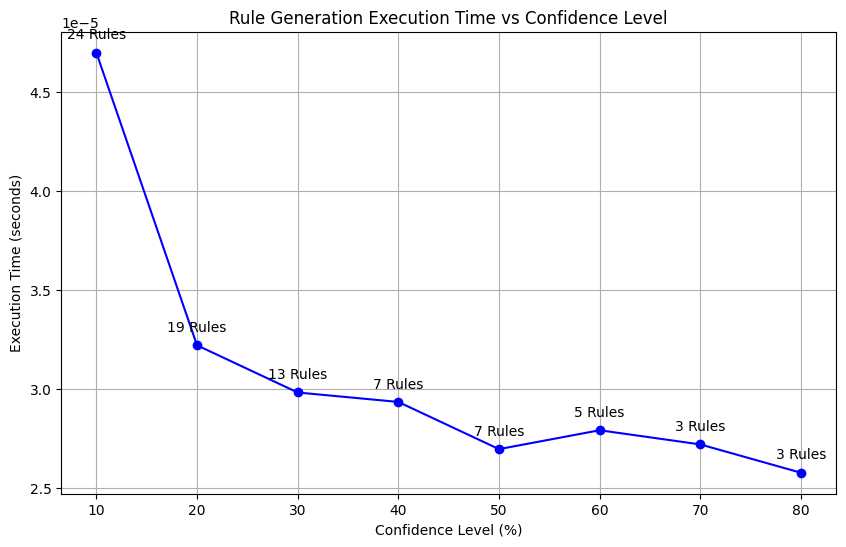

In [6]:
import data_parser
import apriori_algorithm
import rule_generator
import time
import matplotlib.pyplot as plt

def main():
    DATA_FILE = 'T10I4D100K.dat'
    MIN_SUPPORT_PCT = 0.01  
    
    transactions = data_parser.data_parser(DATA_FILE)
    
    num_transactions = len(transactions)
    support_count = MIN_SUPPORT_PCT * num_transactions

    all_frequent_itemsets = {}

    current_frequent_itemsets = apriori_algorithm.get_frequent_singletons(transactions, support_count)
    
    if not current_frequent_itemsets:
        print("No frequent items found.")
        return

    print(f"Found {len(current_frequent_itemsets)} frequent 1-itemsets.")
    all_frequent_itemsets.update(current_frequent_itemsets)
    
    k = 2
    while True:
        # Signature: (previous_k_ton, transaction, support, k)
        next_frequent_itemsets = apriori_algorithm.get_frequent_k_itemsets(
            current_frequent_itemsets, 
            transactions, 
            support_count, 
            k
        )

        if not next_frequent_itemsets:
            print(f"No frequent {k}-itemsets found.")
            break

        print(f"Found {len(next_frequent_itemsets)} frequent {k}-itemsets.")
        
        all_frequent_itemsets.update(next_frequent_itemsets)
        current_frequent_itemsets = next_frequent_itemsets
        k += 1

    print(f"\nTotal unique frequent itemsets found: {len(all_frequent_itemsets)}")

    print("\n--- Benchmarking Rule Generation ---")
    
    confidence_levels = [10, 20, 30, 40, 50, 60, 70, 80]
    execution_times = []
    num_rules_found = []
    last_rules_generated = [] 

    for conf_pct in confidence_levels:
        min_conf = conf_pct / 100.0
        print(f"Generating rules for {conf_pct}% confidence.", end=" ")
        
        start_time = time.time()
        
        # Run the rule generator
        rules = rule_generator.generate_association_rules(all_frequent_itemsets, min_conf)
        
        end_time = time.time()
        elapsed = end_time - start_time
        
        execution_times.append(elapsed)
        num_rules_found.append(len(rules))
        last_rules_generated = rules 
        
        print(f"Done in {elapsed:.8f}s. (Found {len(rules)} rules)")

    print(f"\nExample Output (Top 5 rules at 80% confidence):")
    if last_rules_generated:
        last_rules_generated.sort(key=lambda x: x[2], reverse=True)
        for ant, cons, conf in last_rules_generated[:5]:
             print(f"{list(ant)} -> {list(cons)} (Conf: {conf:.2f})")
    else:
        print("No rules found at the highest confidence level.")

    plt.figure(figsize=(10, 6))
    
    plt.plot(confidence_levels, execution_times, marker='o', linestyle='-', color='b')
    
    plt.title('Rule Generation Execution Time vs Confidence Level')
    plt.xlabel('Confidence Level (%)')
    plt.ylabel('Execution Time (seconds)')
    plt.grid(True)
    plt.xticks(confidence_levels)
    
    for i, txt in enumerate(num_rules_found):
        plt.annotate(f"{txt} Rules", (confidence_levels[i], execution_times[i]), 
                     textcoords="offset points", xytext=(0,10), ha='center')

    print("\nDisplaying graph...")
    plt.show()

if __name__ == "__main__":
    main()